# Contextual Semantic Search with Chroma and LiteLLM

This notebook demonstrates how to build a **Contextual Semantic Search** system using **Chroma Vector Database** and **LiteLLM** with the **Gemini model**. The system processes a folder of PDF documents, builds a knowledge base, and retrieves contextually relevant information to answer user queries. Below is an overview of the tools and methods used.

---

## Tools Used

1. **Chroma Vector Database**:
   - A vector database designed for storing and querying embeddings.
   - Enables efficient similarity search for retrieving semantically relevant documents.

2. **Sentence Transformers**:
   - A library for generating high-quality embeddings (vector representations) of text.
   - Uses pre-trained models like `all-MiniLM-L6-v2` to convert text into embeddings.

3. **LangChain**:
   - A framework for working with text data, including text splitting and chunking.
   - The `RecursiveCharacterTextSplitter` is used to split text into semantically meaningful chunks.

4. **LiteLLM**:
   - A lightweight library for interacting with large language models (LLMs).
   - Used here to call the **Gemini model** for generating responses based on retrieved context.

5. **PyPDF2**:
   - A library for extracting text from PDF files.
   - Used to process all PDFs in a specified folder.

---

## Methods and Steps

### Step 1: Extract Text from PDFs
- All PDF files in a specified folder are processed using **PyPDF2**.
- The text from each PDF is extracted and combined into a single string.

### Step 2: Split Text into Chunks
- The combined text is split into smaller chunks using **LangChain's RecursiveCharacterTextSplitter**.
- This ensures that the chunks are semantically meaningful and retain context.

### Step 3: Generate Embeddings
- Each text chunk is converted into an embedding (vector representation) using **Sentence Transformers**.
- The embeddings capture the semantic meaning of the text.

### Step 4: Build the Knowledge Base
- The embeddings and corresponding text chunks are stored in **Chroma Vector Database**.
- This allows for efficient similarity searches based on semantic meaning.

### Step 5: Perform Semantic Search
- A user query is converted into an embedding.
- The most semantically similar chunks are retrieved from the Chroma database.

### Step 6: Generate Responses
- The retrieved chunks are passed as context to the **Gemini model** via **LiteLLM**.
- The model generates a response based on the query and the provided context.

---

## Workflow Overview

1. **Input**: A folder containing PDF documents.
2. **Processing**:
   - Extract text from PDFs.
   - Split text into chunks.
   - Generate embeddings and store them in Chroma.
3. **Query Handling**:
   - Convert the query into an embedding.
   - Retrieve the most relevant chunks from Chroma.
   - Generate a response using the Gemini model.
4. **Output**: A contextually accurate answer to the user's query.

---

## Why This Approach?

- **Contextual Semantic Search**: Goes beyond keyword matching to understand the meaning and context of the query.
- **Efficient Retrieval**: Chroma enables fast and scalable similarity searches.
- **High-Quality Responses**: The Gemini model generates accurate and contextually relevant answers.

---

Let’s get started! You can see the full workflow in the diagram below.

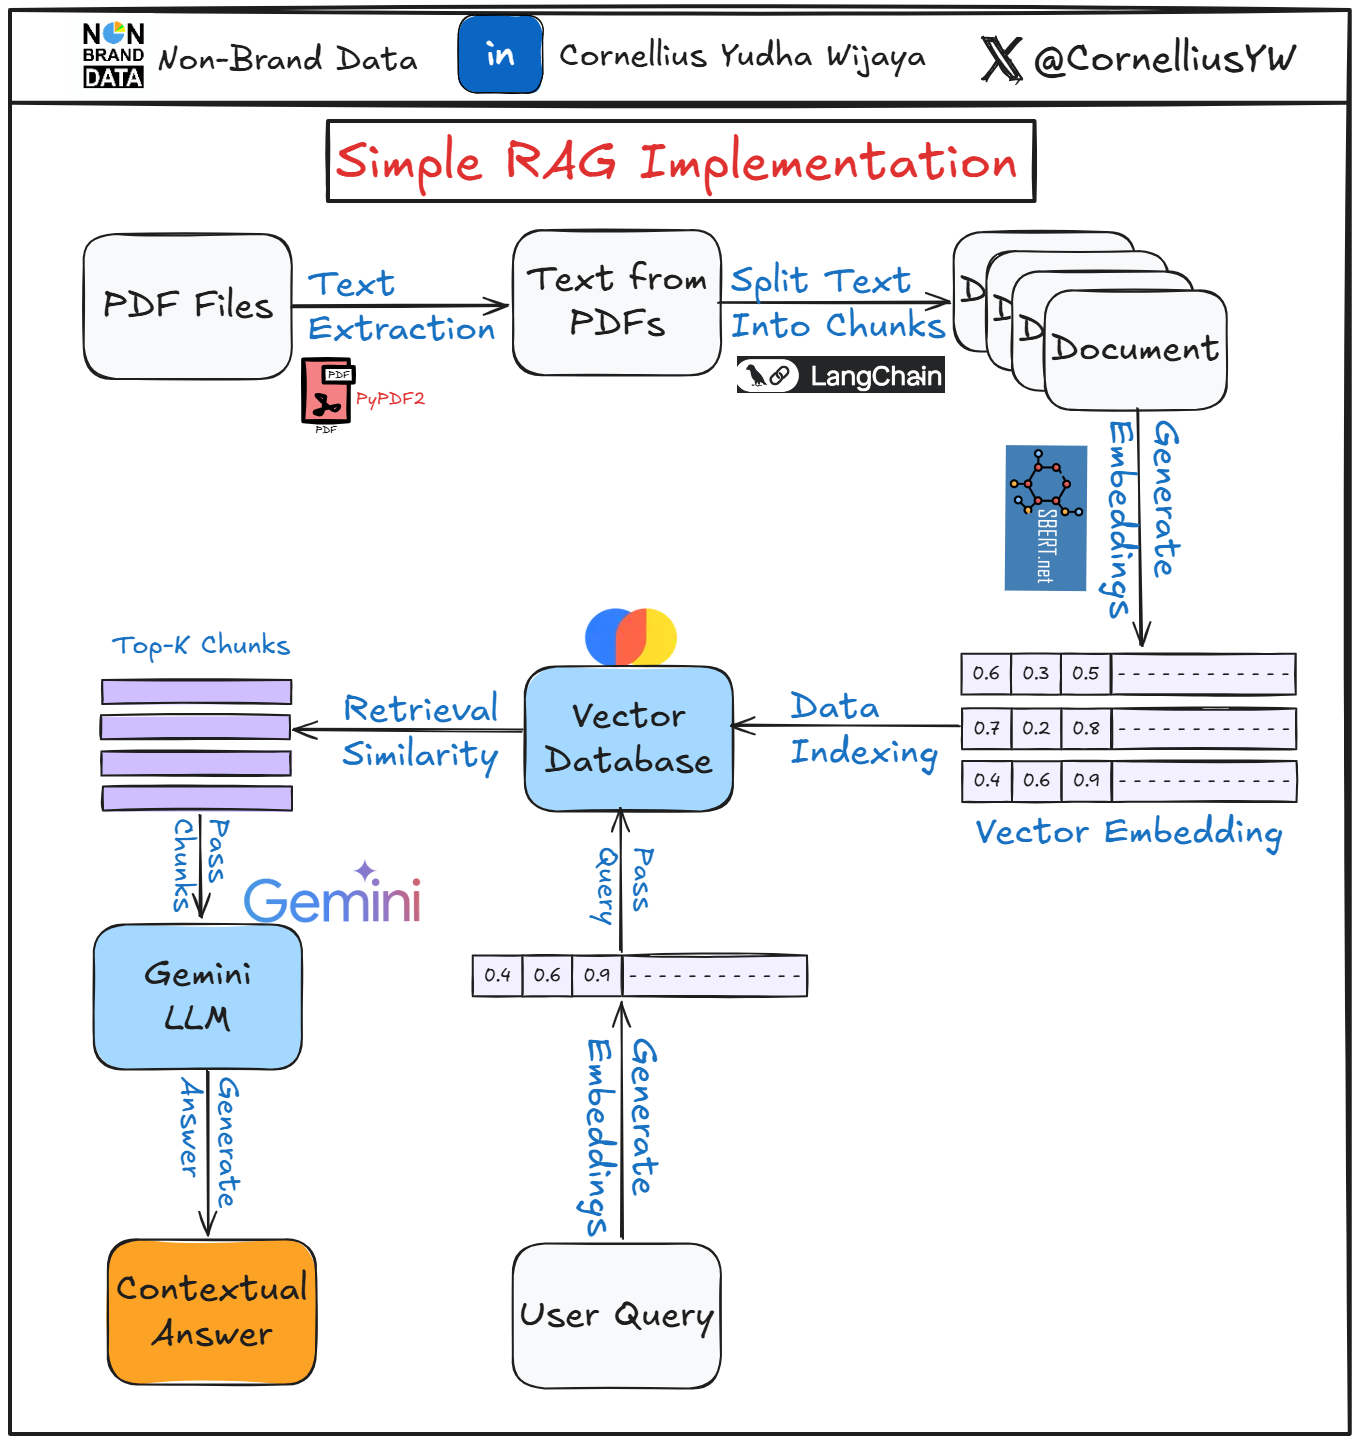

## Library Installation

Start by installing the library used in this Notebook

In [ ]:
!pip install -q chromadb pypdf2 sentence-transformers litellm langchain

## Import the Libraries and set the environment variables

In [5]:
import os
import PyPDF2
from sentence_transformers import SentenceTransformer
import chromadb
from chromadb.config import Settings
import litellm
from litellm import completion
from langchain.text_splitter import RecursiveCharacterTextSplitter

# # Set environment variables. Uncomment this if you want to set them directly.
# os.environ["HUGGINGFACE_TOKEN"] = "your_huggingface_token_here"
# os.environ["GEMINI_API_KEY"] = "your_gemini_api_key_here"
os.environ['LITELLM_LOG'] = 'DEBUG'

# # Retrieve environment variables
# HUGGINGFACE_TOKEN = os.getenv("HUGGINGFACE_TOKEN")
# GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")



## Extract Text from folder containing PDF files

In [ ]:
def extract_text_from_pdfs(folder_path):
    all_text = ""
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'rb') as file:
                reader = PyPDF2.PdfReader(file)
                for page in reader.pages:
                    all_text += page.extract_text()
    return all_text

pdf_folder = "dataset"
all_text = extract_text_from_pdfs(pdf_folder)

## Text Splitter

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Size of each chunk
    chunk_overlap=50,  # Overlap between chunks to maintain context
    separators=["\n\n", "\n", " ", ""]  # Splitting hierarchy
)

chunks = text_splitter.split_text(all_text)

## Set up the Knowledge Base with ChromaDB and Generate Embeddings with sentence-transformers

In [ ]:
# Initialize a persistent ChromaDB client
client = chromadb.PersistentClient(path="chroma_db")

# Load the SentenceTransformer model for text embeddings
text_embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Delete existing collection (if needed)
try:
    client.delete_collection(name="knowledge_base")
    print("Deleted existing collection: knowledge_base")
except Exception as e:
    print(f"Collection does not exist or could not be deleted: {e}")

# Create a new collection for text embeddings
collection = client.create_collection(name="knowledge_base")

# Add text chunks to the collection
for i, chunk in enumerate(chunks):
    # Generate embeddings for the chunk
    embedding = text_embedding_model.encode(chunk)

    # Add to the collection with metadata
    collection.add(
        ids=[f"chunk_{i}"],  # Unique ID for each chunk
        embeddings=[embedding.tolist()],  # Embedding vector
        metadatas=[{"source": "pdf", "chunk_id": i}],  # Metadata
        documents=[chunk]  # Original text
    )

Deleted existing collection: knowledge_base


## Perform Semantic Search with ChromaDB and Embedding Model

In [ ]:
def semantic_search(query, top_k=5):
    # Generate embedding for the query
    query_embedding = text_embedding_model.encode(query)

    # Query the collection
    results = collection.query(
        query_embeddings=[query_embedding.tolist()],
        n_results=top_k
    )
    return results

# Example query
query = "What is the insurance for car?"
results = semantic_search(query)

# Display results
for i, result in enumerate(results['documents'][0]):
    print(f"Result {i+1}: {result}\n")

Result 1: insurance) 
FINANCIAL RESPONSIBILITY LAW
A state law requiring that all automobile 
drivers show proof that they can pay dam-
ages up to a minimum amount if involved 
in an auto accident. Varies from state to 
state but can be met by carrying a mini-
mum amount of auto liability insurance. 
(See Compulsory auto insurance)
FINITE RISK REINSURANCE
Contract under which the ultimate li-
ability of the reinsurer is capped and on 
which anticipated investment income is

Result 2: policyholder’s car from a collision. 
5. Comprehensive, for damage to the poli-
cyholder’s car not involving a collision 
with another car (including damage 
from fire, explosions, earthquakes, floods, and riots), and theft. 6. Uninsured motorists coverage, for costs 
resulting from an accident involving a hit-and-run driver or a driver who does not have insurance. 
AUTO INSURANCE PREMIUM
The price an insurance company charges 
for coverage, based on the frequency and

Result 3: Overview	 I.I.I.	Insurance	

## Generate Repsonse Based on Semantic Search

In [ ]:
# Set up LiteLLM with Gemini

def generate_response(query, context):
    # Combine the query and context for the prompt
    prompt = f"Query: {query}\nContext: {context}\nAnswer:"

    # Call the Gemini model via LiteLLM
    response = completion(
        model="gemini/gemini-1.5-flash",  # Use the Gemini model
        messages=[{"content": prompt, "role": "user"}],
        api_key= GEMINI_API_KEY
    )

    # Extract and return the generated text
    return response['choices'][0]['message']['content']

# Retrieve the top results from semantic search
search_results = semantic_search(query)
context = "\n".join(search_results['documents'][0])

# Generate a response using the retrieved context
response = generate_response(query, context)
print("Generated Response:\n", response)

15:22:16 - LiteLLM:WARNING: utils.py:325 - `litellm.set_verbose` is deprecated. Please set `os.environ['LITELLM_LOG'] = 'DEBUG'` for debug logs.


SYNC kwargs[caching]: False; litellm.cache: None; kwargs.get('cache')['no-cache']: False
Final returned optional params: {}
RAW RESPONSE:
{
  "candidates": [
    {
      "content": {
        "parts": [
          {
            "text": "Based on the provided text, car insurance, or auto insurance, protects against financial loss from an accident.  It's a contract where the policyholder pays a premium, and the insurance company pays for losses as defined in the policy.  The insurance provides property, liability, and medical coverage.  Property coverage pays for damage to or theft of the car.  Liability insurance pays the other driver's costs if the policyholder is at fault.  The text also mentions comprehensive coverage (damage not involving a collision) and uninsured motorists coverage.\n"
          }
        ],
        "role": "model"
      },
      "finishReason": "STOP",
      "citationMetadata": {
        "citationSources": [
          {
            "startIndex": 241,
            "e

## Set up the Test Dataset for RAG Evaluation

In [ ]:
import pandas as pd
#find it in the generated dataset folder if you miss it
df = pd.read_csv('evaluation_results_question_insurance.csv')

## Set the Prompt for Context Relevance Evaluation

In [ ]:
from tqdm import tqdm

# Define evaluation criteria
chunk_validation_prompt_template = """
{task}
{evaluation_criteria}

Follow these steps to generate your evaluation:
{evaluation_steps}

Please respond using the following JSON schema:

Answer = {json_format}

You MUST provide values for 'Evaluation:' and 'Score' in your answer.

{question}
{context}

Answer: """

rating_json_format = """
{
    "Evaluation": "your rationale for the rating, as a text",
    "Score": "your rating, as a number between 1 and 5"
}
"""

question_template = """Now here are the question (delimited by triple backticks)
Question: ```{question}```
"""

context_template = """here are the context (delimited by triple quotes).
Context: \"\"\"{context}\"\"\"\n
"""

# Tasks, evaluation criteria, and steps
context_evaluation_task = """You will be given a context and a question.
Your task is to evaluate the question based on the given context and provide a score between 1 and 5 according to the following criteria:"""

context_evaluation_task = """- Score 1: The context does not provide sufficient information to answer the question in any way.
- Score 2 or 3: The context provides some relevant information, but the question remains partially answerable, or is unclear/ambiguous.
- Score 4: The context offers sufficient information to answer the question, but some minor details are missing or unclear.
- Score 5: The context provides all necessary information to answer the question clearly and without ambiguity."""

context_evaluation_task = """- Read the context and question carefully.
- Analyse and evaluate the question based on the provided evaluation criteria.
- Provide a scaled score between 1 and 5 that reflect your evaluation."""

## Preparing the LLM Evaluator for Evaluation based on the Generated Question

In [ ]:
import time
import json

# Define the request and token limits
REQUEST_LIMIT = 15  # Maximum requests per minute
TOKEN_LIMIT = 1_000_000  # Maximum tokens per minute

# Initialize counters for rate limiting
start_time = time.time()
requests_made = 0
tokens_used = 0

# Define the function to enforce rate limits
def enforce_rate_limit(start_time, requests_made, tokens_used):
    elapsed_time = time.time() - start_time
    if requests_made >= REQUEST_LIMIT or tokens_used >= TOKEN_LIMIT:
        sleep_time = max(0, 60 - elapsed_time)  # Wait until 1 minute has passed
        time.sleep(sleep_time)
        return time.time(), 0, 0  # Reset counters
    return start_time, requests_made, tokens_used

# Define the function to evaluate groundness
def evaluate_groundness(question, context):
    global start_time, requests_made, tokens_used
    
    # Enforce rate limits
    start_time, requests_made, tokens_used = enforce_rate_limit(start_time, requests_made, tokens_used)
    
    # Prepare the prompt for groundness evaluation
    prompt = f"""
    {groundedness_task}

    {groundedness_eval}

    {groundedness_steps}

    Please respond using the following JSON schema:

    {rating_json_format}

    Now here is the question (delimited by triple backticks):
    Question: ```{question}```

    Here is the context (delimited by triple quotes):
    Context: \"\"\"{context}\"\"\"
    """
    
    # Generate the response using Gemini
    response = generate_response(prompt, "")
    
    # Update the counters
    requests_made += 1
    tokens_used += len(prompt.split())  # Approximate token count
    
    # Parse the response
    try:
        # Extract JSON part from the response (if any)
        json_start = response.find("{")
        json_end = response.rfind("}") + 1
        json_response = response[json_start:json_end]
        evaluation = json.loads(json_response)
        return evaluation
    except json.JSONDecodeError:
        return {"Evaluation": "Invalid JSON response", "Score": 0}

## Looping through questions and each chunk retrieved for judge

In [ ]:
results = []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    question = row['question']
    
    # Perform semantic search
    search_results = semantic_search(question, top_k=2)
    
    # Evaluate each chunk
    for i, context in enumerate(search_results['documents'][0]):
        evaluation = evaluate_groundness(question, context)
        results.append({
            "question": question,
            "context": context,
            "evaluation": evaluation
        })
    
    # Enforce rate limits after each question
    start_time, requests_made, tokens_used = enforce_rate_limit(start_time, requests_made, tokens_used)

# Display the results
for result in results:
    print(f"Question: {result['question']}")
    print(f"Context: {result['context']}")
    print(f"Evaluation: {result['evaluation']['Evaluation']}")
    print(f"Score: {result['evaluation']['Score']}\n")

# Prepare the DataFrame and save the result

In [ ]:
# Convert the results list to a DataFrame
results_df = pd.DataFrame(results)

# Flatten the 'evaluation' column into separate columns
results_df = pd.concat(
    [results_df.drop(columns=["evaluation"]), results_df["evaluation"].apply(pd.Series)],
    axis=1
)

results_df.rename(columns={"Evaluation": "Evaluation_Rationale", "Score": "Evaluation_Score"}, inplace=True)


# Optionally, save the DataFrame to a CSV file
results_df.to_csv("RAG_evaluation_results.csv", index=False)

## Log the result

In [ ]:
import mlflow

# Set the tracking URI and experiment name
mlflow.set_tracking_uri("http://localhost:5000")
EXPERIMENT_NAME = "RAG-Question-Evaluation-Insurance"
mlflow.set_experiment(EXPERIMENT_NAME)

with mlflow.start_run():
    # Log parameters
    mlflow.log_param("model_name", "gemini-1.5-flash")

    groundedness_scores = rag_result['Evaluation_Score'].dropna()

    mlflow.log_metric("average_groundedness_score", groundedness_scores.mean())

    print("Results logged to MLflow.")